In [7]:
# image processing
import cv2

# image showing
from matplotlib import pyplot as plt

# mathematical operation
import math

In [19]:
class Image:
	''' - store information about image
	'''

	def __init__( self, image, imageNameStr ):
		self.image = image
		self.rgbImage = cv2.cvtColor( self.image, cv2.COLOR_BGR2RGB )
		self.imageNameStr = imageNameStr

class ImagePlotter:
	''' - used to dynamically create image plot using matplotlib
	'''

	def __init__( self, widthPerImageInch, heightPerImageInInch, numberOfColumn ):
		
		# matplotlib pyplot
		self.plt  = plt

		# image width
		self.widthPerImageInch = widthPerImageInch

		# overall width of figure
		self.overallImageWidthInInch = self.widthPerImageInch * numberOfColumn

		# image height
		self.heightPerImageInInch = heightPerImageInInch

		# all image to plot in this figure
		self.imageObjStorageList = []

		# set number of column in figure
		self.numberOfColumn = numberOfColumn

		# number of row 
		self.numberOfRow = None

		# number of image 
		self.numberOfImage = None

		# figure 
		self.figure = None

	def addImageToPlot( self, image, imageNameStr ):
		''' - add image to be plotted
		'''

		# create image object
		imageObj = Image( image, imageNameStr )

		# store image object
		self.imageObjStorageList.append( imageObj )

	def plotAndShowAllImage( self ):
		''' - construct all image in figure and show them 
		'''

		# get number of image in figure
		self.numberOfImage = len( self.imageObjStorageList )

		# calculate overall plot height in inches
		self.overallImageHeightInInch = self.numberOfImage * self.heightPerImageInInch

		# calculate number of row
		self.numberOfRow = math.ceil( self.numberOfImage / self.numberOfColumn )

		# create figure
		self.figure = self.plt.figure( figsize = ( self.overallImageWidthInInch, self.overallImageHeightInInch ) )

		# loop through image object 
		for imagePosition, imageObj in enumerate( self.imageObjStorageList ):

			# set position of image
			self.figure.add_subplot( self.numberOfRow, self.numberOfColumn, imagePosition + 1 )

			# add image to figure
			self.plt.imshow( imageObj.rgbImage )

			# not show the axis
			self.plt.axis( 'off' )

			# set image title
			self.plt.title( imageObj.imageNameStr )
		
		# show figure
		plt.show()

In [103]:
def filterContoursOnlyInAreaRange( contourList, minArea=0, maxArea=0 ):
	''' - get only contour in area range

		ARGS:
			- contourList ( list )
			- minArea ( int )
			- maxArea ( int )

		RETURN:
			- contourListInAreaRange ( list )
	'''

	# contour in area range storage
	contourListInAreaRange = []

	# loop through each contour
	for contour in contourList:

		# calculate contour area
		contourArea = cv2.contourArea( contour )

		# this contour is in range
		if minArea <= contourArea <= maxArea:
			
			# store it
			contourListInAreaRange.append( contour )
	return contourListInAreaRange

def approximatePolygonOfContour( contour, epsilonPercent ):
	''' - approximate polygon of contour to be a rougher shape

		- mainly used for shape analysis

		- usually set epsilon parameter to 1 - 5 % of contour's perimeter
	'''

	# calculate contour perimeter
	contourPerimeter = cv2.arcLength( contour, True )

	# approximate curve of contour
	approximatedPointList = cv2.approxPolyDP( contour,  epsilonPercent / 100 * contourPerimeter, True )
	return approximatedPointList

def isCircleContour( contour, epsilonPercent, errorPercent ):
	''' - check if this is a circle contour

		- this contour in circle if:
			- approximate point is more than5
			- bounding box has square aspect ratio
	'''

	# calculate approximation curve of contour
	approximatedPointList = approximatePolygonOfContour( contour, epsilonPercent  )

	# contour has polygon approximation point more than 5
	if len( approximatedPointList ) > 5:

		# calculate approximation polygon bounding box
		( xPosition, yPosition, boundingBoxWidth, boundingBoxHeight ) = cv2.boundingRect( approximatedPointList )
		
		# calculate aspect ratio of bounding box
		boundingBoxAspectRatio = boundingBoxWidth / boundingBoxHeight

		# calculate acceptable error
		acceptableError = errorPercent / 100 

		# this bounding box is square
		if 1 - acceptableError <= boundingBoxAspectRatio <= 1 + acceptableError:
			
			# this contour is circle
			return True
		
	# this contour is not circle
	return False

def isTriangleContour( contour, epsilonPercent ):
	''' - check if this is a triangle shape

		- this contour is triangle if:
			- it approximation curve has 3 points 
	''' 

	# calculate approximation curve of contour
	approximatedPointList = approximatePolygonOfContour( contour, epsilonPercent  )

	# this is triangle shape contour
	if len( approximatedPointList ) == 3:
		return True
	
	# this is not a triangle contour
	return False

def isSquareContour( contour, epsilonPercent, errorPercent ):
	''' - check if this contour is square shape

		- this contour is square contour if:
			- its approximation curve has 4 points
			- its bounding box has an aspect ration close to 1
	'''

	# calculate approximation curve of contour
	approximatedPointList = approximatePolygonOfContour( contour, epsilonPercent  )

	# contour has polygon approximation point equal to 4
	if len( approximatedPointList ) == 4:

		# calculate approximation polygon bounding box
		( xPosition, yPosition, boundingBoxWidth, boundingBoxHeight ) = cv2.boundingRect( approximatedPointList )
		
		# calculate aspect ratio of bounding box
		boundingBoxAspectRatio = boundingBoxWidth / boundingBoxHeight

		# calculate acceptable error
		acceptableError = errorPercent / 100 

		# this bounding box is square
		if 1 - acceptableError <= boundingBoxAspectRatio <= 1 + acceptableError:
			
			# this is square contour
			return True
		
	# this contour is not square
	return False

def isOuterMostContour( contour, otherContourList ):
	''' - check to see if this contour is NOT inside any of the other contour
	'''

	# approximate polygon of contour
	approximatedPolygonList = approximatePolygonOfContour( contour, 4 )

	# loop through each point in contour
	for otherContour in otherContourList:

		# loop each point in approximated polygon
		for point in approximatedPolygonList:

			pointTuple = ( int( point[ 0 ][ 0 ] ), int( point[ 0 ][ 1 ] ) )

			# point is inside other approximated polygon
			if cv2.pointPolygonTest( otherContour, pointTuple, False ) > 0:
				
				# this is NOT the outer most contour
				return False

	# this is the outer most contour
	return True

8 1


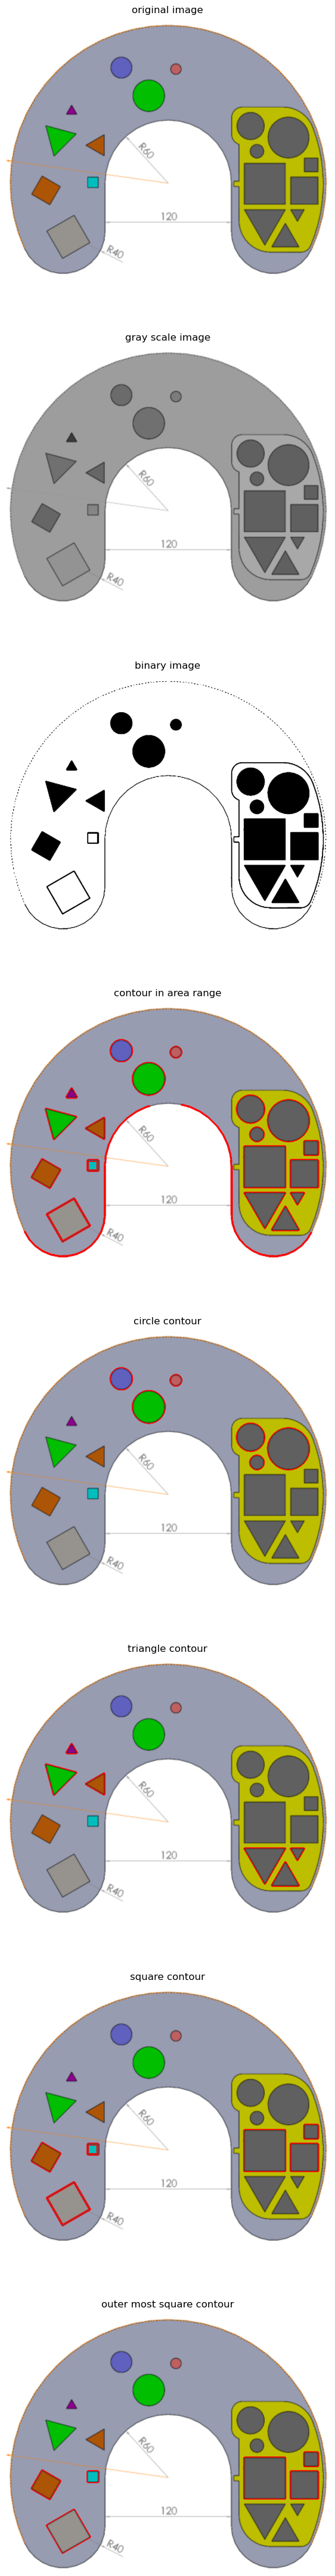

In [104]:
# create image plotter object
imagePlotter = ImagePlotter( 7, 7, 1 )

# reading image
originalImage = cv2.imread( 'field_image_from_manual.png' )

# add original image to figure
imagePlotter.addImageToPlot( originalImage, 'original image' )

# converting image into grayscale image
grayScaleImage = cv2.cvtColor( originalImage, cv2.COLOR_BGR2GRAY )

# add gray scale image to figure 
imagePlotter.addImageToPlot( grayScaleImage, 'gray scale image' )

# convert to binary image
_, binaryImage = cv2.threshold( grayScaleImage, 127, 255, cv2.THRESH_BINARY )

# add binary image to figure 
imagePlotter.addImageToPlot( binaryImage, 'binary image' )

# using a findContours() function
contourList, _ = cv2.findContours( binaryImage, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE )

# filter contour by area
contourInAreaRangeList = filterContoursOnlyInAreaRange( contourList, 1000, 100000 )

# copy original image to draw contour in area range
originalImageForDrawContourInAreaRange = originalImage.copy()

# loop through contour in area range
for contour in contourInAreaRangeList:
	
	# using drawContours() function
	cv2.drawContours( originalImageForDrawContourInAreaRange, [ contour ], 0, (0, 0, 255), 3 )

# add original image with contour in area range to figure 
imagePlotter.addImageToPlot( originalImageForDrawContourInAreaRange, 'contour in area range' )

# copy original image to draw circle contour
originalImageForDrawCircleContour = originalImage.copy()

# outer most circle contour storage

# copy original image to draw triangle contour
originalImageForDrawTriangleContour = originalImage.copy()

# copy original image to draw square contour
originalImageForDrawSquareContour = originalImage.copy()

# square contour storage
squareContourList = []

# loop through contour in area range
for contour in contourInAreaRangeList:

	# this is circle contour
	if isCircleContour( contour, 4, 6 ):
	
		# draw contour in image for circle contour
		cv2.drawContours( originalImageForDrawCircleContour, [ contour ], 0, (0, 0, 255), 3 )
		continue

	# this is triangle contour
	elif isTriangleContour( contour, 5 ):

		# draw contour in image for triangle contour
		cv2.drawContours( originalImageForDrawTriangleContour, [ contour ], 0, (0, 0, 255), 3 )
		continue

	# this is square contour
	elif isSquareContour( contour, 4, 5 ):

		# store this contour
		squareContourList.append( contour )

		# draw contour in image for square contour
		cv2.drawContours( originalImageForDrawSquareContour, [ contour ], 0, (0, 0, 255), 3 )
		continue


# add original image with circle contour 
imagePlotter.addImageToPlot( originalImageForDrawCircleContour, 'circle contour' )

# add original image with triangle contour 
imagePlotter.addImageToPlot( originalImageForDrawTriangleContour, 'triangle contour' )

# add original image with square contour 
imagePlotter.addImageToPlot( originalImageForDrawSquareContour, 'square contour' )

# outer most square contour storage
outerMostSquareContourList = []

# copy original image to draw outer most square contour
originalImageForDrawOuterMostSquareContour = originalImage.copy()

# loop each square contour
for squareContour in squareContourList:

	# this is the outer most contour
	if isOuterMostContour( squareContour, squareContourList ):

		# store it
		outerMostSquareContourList.append( squareContour )

		# draw contour in image for outer most square contour
		cv2.drawContours( originalImageForDrawOuterMostSquareContour, [ squareContour ], 0, (0, 0, 255), 3 )

# add original image with outer most square contour to figure
imagePlotter.addImageToPlot( originalImageForDrawOuterMostSquareContour, 'outer most square contour' )

# show figure
imagePlotter.plotAndShowAllImage()